## Analysis notebook for atmosphere NetCDF files

### Define utils

In [1]:
import numpy as np
import netCDF4 as nc
import glob
import os
from scipy.interpolate import PchipInterpolator

import matplotlib as mpl
font = {'family' : 'sans',
        'size'   : 12}

mpl.rc('font', **font)
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MultipleLocator, LogLocator, MaxNLocator
import matplotlib.pyplot as plt

import pandas as pd
from cmcrameri import cm


In [2]:
from proteus.config import read_config
import utils.load_grid as lg

In [3]:
%matplotlib inline
# %config InlineBackend.figure_format='retina'

# %matplotlib widget

In [4]:
def readrun(f, stride=1):
    print("Reading files in '%s'..." % f)
    ncdfs = glob.glob(f+"/data/*_atm.nc")
    if len(ncdfs) == 0:
        raise Exception("No files found!")

    years = [float(s.split("/")[-1].split("_")[0]) for s in ncdfs]

    if stride < 0:
        mask = [np.argsort(years)[-1]]
    else:
        mask = np.argsort(years)[::int(stride)]

    ncdfs = np.array([ncdfs[i] for i in mask])
    years = np.array([years[i] for i in mask])
    data  = np.array([lg.readncdf(f) for f in ncdfs])

    print("    Done reading %d files" % len(years))
    print("    Final time = %1.3e years" % years[-1])
    return years, data

def read_helpfile(fpath):
    return pd.read_csv(fpath, sep=r'\s+')



### Do analysis

In [37]:
outname = "output/hd63433d_Teff/"
title = "HD 63433 d"

stride = -1

indep_var = "star.dummy.Teff"
indep_lbl = r"Stellar T$_{\text{eff}}$ [K]"

cmap = cm.batlow

In [99]:
globber = os.path.join(os.environ.get("HOME"),"analysis/data/",outname) + "/case_*/"
print(globber)
cases = glob.glob(globber)

npoints = len(cases)
print("npoints = %d"%npoints)
if npoints < 1:
    raise

data = []
help = []
conf = []
post = []
for folder in cases:
    _,d = readrun(folder, stride=stride)
    data.append( d )
    conf.append( read_config(folder+"init_coupler.toml") )
    help.append( read_helpfile(folder+"runtime_helpfile.csv") )

indep_vals = []
for i in range(npoints):
    indep_vals.append(lg.descend_get(conf[i],indep_var))
indep_max = np.amax(np.abs(indep_vals))
indep_min = np.amin(np.abs(indep_vals))

isorted = np.argsort(indep_vals)

print("Done")

/home/n/nichollsh/analysis/data/output/hd63433d_Teff//case_*/
npoints = 17
Reading files in '/home/n/nichollsh/analysis/data/output/hd63433d_Teff/case_00000/'...
    Done reading 1 files
    Final time = 2.336e+08 years
Reading files in '/home/n/nichollsh/analysis/data/output/hd63433d_Teff/case_00001/'...
    Done reading 1 files
    Final time = 1.571e+08 years
Reading files in '/home/n/nichollsh/analysis/data/output/hd63433d_Teff/case_00002/'...
    Done reading 1 files
    Final time = 9.602e+07 years
Reading files in '/home/n/nichollsh/analysis/data/output/hd63433d_Teff/case_00003/'...
    Done reading 1 files
    Final time = 7.420e+07 years
Reading files in '/home/n/nichollsh/analysis/data/output/hd63433d_Teff/case_00004/'...
    Done reading 1 files
    Final time = 3.085e+07 years
Reading files in '/home/n/nichollsh/analysis/data/output/hd63433d_Teff/case_00005/'...
    Done reading 1 files
    Final time = 2.039e+07 years
Reading files in '/home/n/nichollsh/analysis/data/outpu

In [39]:
norm = mpl.colors.Normalize(vmin=indep_min, vmax=indep_max)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

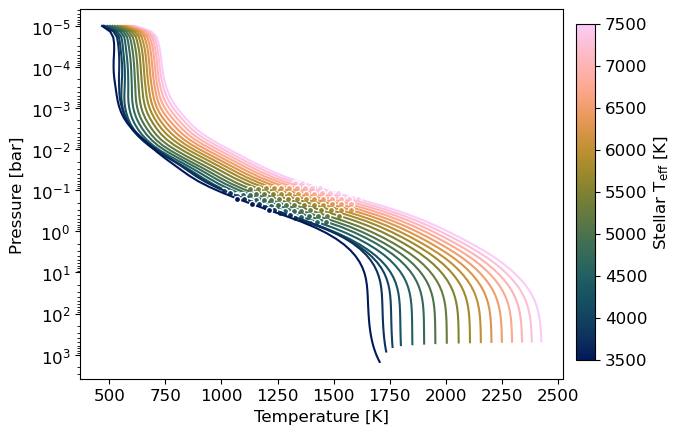

In [163]:
plt.close("all")
fig,ax = plt.subplots(1,1)

for i in range(npoints):
    ds = data[i][-1]
    x = ds["tmpl"]
    y = ds["pl"] * 1e-5

    indep_val = lg.descend_get(conf[i],indep_var)
    col = sm.to_rgba(indep_val)
    zorder=isorted[::-1][i]

    ax.plot(x,y, color=col, zorder=2*zorder)

    m = np.argwhere(ds["fl_cnvct"] > 0)
    x = x[m]
    y = y[m]
    ax.scatter(x,y, color=col, s=20, edgecolors='w', marker='o', zorder=2*zorder+1)

ax.set_yscale("log")
ax.invert_yaxis()
ax.set_ylabel("Pressure [bar]")
ax.set_xlabel("Temperature [K]")

fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label(indep_lbl)

plt.show()

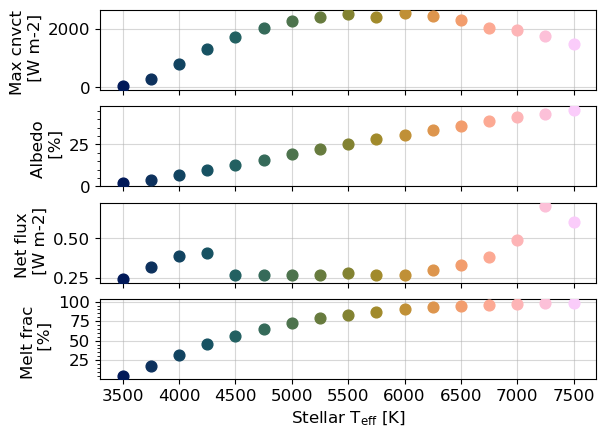

In [180]:
fig,axs = plt.subplots(4,1, sharex=True)
(ax0,ax1,ax2,ax3) = axs

ms=60
lvl = 0

for i in range(npoints):
    ds = data[i][-1]
    hf = help[i].iloc[-1]
    indep_val = lg.descend_get(conf[i],indep_var)
    col = sm.to_rgba(indep_val)

    zorder=10

    ax0.set_ylabel("Max cnvct \n [W m-2]")
    y = np.amax(ds["fl_cnvct"])
    ax0.scatter(indep_val,y, color=col, s=ms, zorder=zorder)

    ax1.set_ylabel("Albedo \n [%]")
    ax1.yaxis.set_major_locator(MultipleLocator(25))
    ax1.yaxis.set_minor_locator(MultipleLocator(5))
    y = ds["fl_U_SW"][lvl]/ds["fl_D_SW"][lvl] * 100
    ax1.scatter(indep_val,y, color=col, s=ms, zorder=zorder)

    ax2.set_ylabel("Net flux \n [W m-2]")
    y = ds["fl_tot"][lvl]
    ax2.scatter(indep_val,y, color=col, s=ms, zorder=zorder)

    ax3.set_ylabel("Melt frac \n [%]")
    ax3.yaxis.set_major_locator(MultipleLocator(25))
    ax3.yaxis.set_minor_locator(MultipleLocator(5))
    y = hf["Phi_global"] * 100
    ax3.scatter(indep_val,y, color=col, s=ms, zorder=zorder)


for ax in axs:
    ax.grid(zorder=0, alpha=0.5)
axs[-1].set_xlabel(indep_lbl)

plt.show()

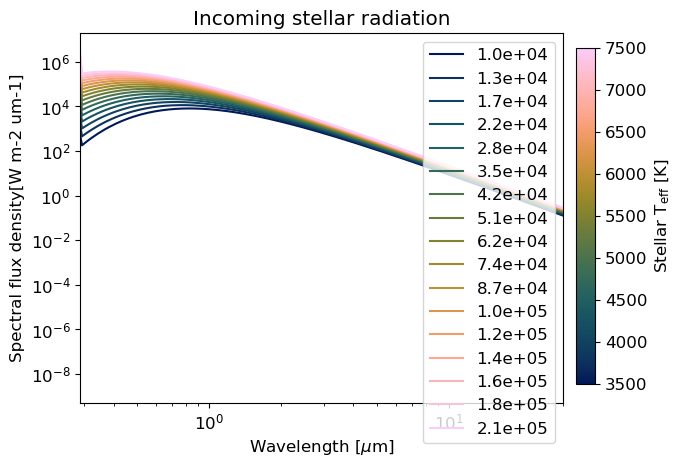

In [96]:
fig,ax = plt.subplots(1,1)

for i in range(npoints):
    ds = data[i][-1]
    x = (ds["bandmin"] + ds["bandmax"]) * 0.5 * 1e6
    w = (ds["bandmax"] - ds["bandmin"]) * 1e6
    y = ds["ba_D_SW"][0]/w

    S_0 = np.trapz(y=y,x=x)


    indep_val = lg.descend_get(conf[i],indep_var)
    col = sm.to_rgba(indep_val)

    ax.plot(x,y, color=col, label="%.1e"%S_0)

ax.set_title("Incoming stellar radiation")
ax.set_yscale("log")
ax.set_ylabel("Spectral flux density[W m-2 um-1]")

ax.set_xscale("log")
ax.set_xlim(left=0.29, right=30)
ax.set_xlabel(r"Wavelength [$\mu$m]")

ax.legend()

fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label(indep_lbl)

plt.show()